# Exercises notebook 
##Imports and definitions
### First things firsts. Here we will import all necessary libraries and defined earlier functions to make your tasks more oriented just on Wavelets

In [106]:
import pywt # Library for wavelets operations
import numpy as np # Library for array and matrix manipulations
import math # Librarry for many mathematical operations
import tftb # time-frequency-tool-box - signal processing
from scipy.special import expit
from scipy import misc
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt # Library for ploting
import matplotlib as mpl
from skimage import util
from scipy import ndimage

In [3]:
def plot_orthogonal_wavelet_aprox(wavelet, level):
    phi, psi, x = wavelet.wavefun(level)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches(15,4)
    ax1.plot(x,phi, color = 'red', label = 'Scalling')
    ax2.plot(x, psi, color = 'green', label = 'Wavelet')
    ax1.set_title('Scalling function', color = 'red')
    ax2.set_title('Wavelet function', color ='green')

def plot_not_orthogonal_wavelet_aprox(wavelet, level):
    phi_d, psi_d, phi_r, psi_r, x = wavelet.wavefun(level)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
    f.set_size_inches(15,8)
    ax1.plot(x, phi_r, color = 'red', label = 'Scalling')
    ax1.set_title('Reconstruction scalling', color ='red')
    ax2.plot(x, psi_r, color = 'green', label = 'Wavelet')
    ax2.set_title('Reconstruction wavelet', color ='green')
    ax3.plot(x, phi_d, color = 'blue', label = 'Scalling')
    ax3.set_title('Decomposition scalling', color ='blue')
    ax4.plot(x, psi_d, color = 'orange', label = 'Wavelet')
    ax4.set_title('Decomposition wavelet', color ='orange')
    
def plot_decomposition_coefficients(coeffs):
    colors=['b','g','r','c','m','y','k']
    f, ax =plt.subplots(len(coeffs),1,sharex=True)
    f.set_size_inches(15,2*len(coeffs))
    ax[0].plot(coeffs[0], color='blue', label="aproximated coeff")
    ax[0].legend()
    for i in xrange(1, len(coeffs)):
        ax[i].plot(coeffs[i], color=colors[i%7], label=("detailed coeff level:"+str(len(coeffs)-i)))
        ax[i].legend()

def plot_matrix_coeff(image, coeffs):
    ca,(cd11, cd12, cd13) = coeffs
    fig = plt.figure(figsize=(15,7))
    a=fig.add_subplot(2,3,4)
    a.imshow(cd11, cmap=plt.cm.gray)
    a.set_title('horrizontal detail')
    a=fig.add_subplot(2,3,5)
    a.set_title('vertical detail')
    a.imshow(cd12, cmap=plt.cm.gray)
    a=fig.add_subplot(2,3,6)
    a.set_title('diagonal detail')
    a.imshow(cd13, cmap=plt.cm.gray)
    a=fig.add_subplot(2,3,1)
    a.imshow(image, cmap=plt.cm.gray)
    a.set_title('original image')
    a=fig.add_subplot(2,3,2)
    a.imshow(ca, cmap=plt.cm.gray)
    a.set_title('aproximation')
    a=fig.add_subplot(2,3,3)
    a.imshow(sum(coeffs[1]), cmap=plt.cm.gray)
    a.set_title('composition of details')

def interpolate_coefs_to_same_length(coeff_1, coeff_2):
    real_coeff_1 = np.real(coeff_1)
    real_coeff_2 = np.real(coeff_2)
    interp_len = len(real_coeff_1)
    real_coeff_2_x = np.linspace(0,len(real_coeff_2),len(real_coeff_2))
    real_coeff_2_interp_x = np.linspace(0,len(real_coeff_2), interp_len)
    real_coeff_2_interp_y = np.interp(real_coeff_2_interp_x, real_coeff_2_x, real_coeff_2)
    return real_coeff_2_interp_y

def plot_detailed_decomposition_coefficients(coeffs, coeffs_thr, thr):
    number_of_details = len(coeffs)-1
    length_of_longest_detail = len(np.real(coeffs[-1]))
    fig = plt.figure(figsize=(15, number_of_details*3))
    max_y =[]
    interp_details = [np.real(coeffs[-1])]
    interp_thr_details = [np.real(coeffs_thr[-1])]
    for detail in xrange(1, number_of_details):
        max_y.append(max(np.real(coeffs[-detail])))
        interp_details.append(np.abs(interpolate_coefs_to_same_length(coeffs[-1], coeffs[-detail-1])))
        interp_thr_details.append(np.abs(interpolate_coefs_to_same_length(coeffs_thr[-1], coeffs_thr[-detail-1])))
    interp_details.append(np.abs(interpolate_coefs_to_same_length(coeffs[-1], coeffs[1])))
    max_y=max(max_y)
    interp_thr_details.append(np.abs(interpolate_coefs_to_same_length(coeffs_thr[-1], coeffs_thr[1])))
    for detail in xrange(1, number_of_details+1):
        ax = plt.subplot2grid((number_of_details, number_of_details),(detail-1, 0), rowspan=1, colspan=1)
        ax.plot(coeffs[-detail], color='green')
        ax.axhline(threshold,color='orange',linestyle='--')
        ax.axhline(-threshold,color='orange',linestyle='--')
        ax.set_ylim(-max_y, max_y)
        ax.set_xticks([])
        ax.set_ylabel('Detail:'+str(detail),rotation=90)
        ax.set_axis_bgcolor('black')
        ax.set_xlim(0, len(coeffs[-detail]))
    ax_org_det = plt.subplot2grid((4, number_of_details),(0, 1),rowspan=number_of_details//2,colspan=3)
    ax_thr_det = plt.subplot2grid((4, number_of_details),(number_of_details//2, 1),rowspan=number_of_details//2,colspan=3)
    
    X,Y = np.meshgrid(range(length_of_longest_detail),range(number_of_details+1))
    Z = np.array(np.abs(interp_details))
    Z_thr = np.array(np.abs(interp_thr_details))
    
    ax_org_det.pcolormesh(X,Y,Z,cmap = 'copper')
    ax_org_det.set_yticks([i for i in range(number_of_details+1)])
    ax_org_det.set_xlim(0, length_of_longest_detail)
    
    ax_thr_det.pcolormesh(X,Y,Z_thr,cmap = 'copper')
    ax_thr_det.set_yticks([i for i in range(number_of_details+1)])
    ax_thr_det.set_xlim(0, length_of_longest_detail)
    
    plt.show()
    
def plot_signal_comparision(clean_signal, noised_signal, reconstructed_signal):
    f, ax =plt.subplots(1,1)
    f.set_size_inches(15,7)
    ax.plot(noised_signal, color='blue', label='noised signal')
    ax.plot(reconstructed_signal, color='red', label='reconstructed signal')
    ax.plot(clean_signal, color='yellow', label='original signal')
    ax.legend()
    
def compute_eliminated_coeff_ratio(coeff, coeff_thr):
    eliminated=0
    total = 0
    for i in xrange(1, len(coeff)):
        eliminated += (coeff_thr[i]==0).sum()-(coeff[i] == 0).sum()
        total += len(coeff[i])
    total += len(coeff[0])
    return(float(eliminated)/total)

## 1-d signal noise removal
####In this exercise your task is to remove noise from Doppler signal.
Try to find proper wavelet, decomposition level and threshold to perform that on given signal.
Then compare this result with fast Fourier transform and find out what's better approach in this situation :>


In [5]:
fm, am, _ = tftb.generators.doppler(1024.0, 200.0, 400.0 / 60.0, 10.0, 50.0)
signal = am * fm
noise = tftb.generators.noisecu(1024)
noised_signal = tftb.generators.sigmerge(signal, noise, -5)

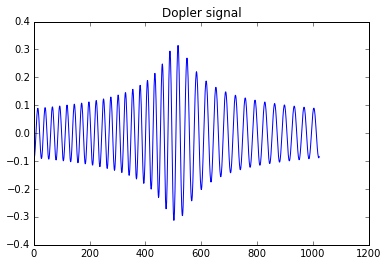

In [7]:
plt.plot(np.real(signal))
plt.title("Dopler signal")

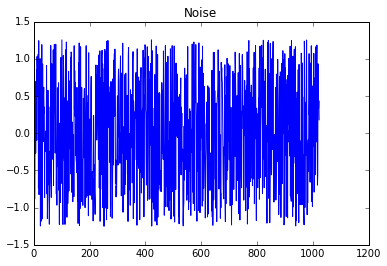

In [10]:
plt.plot(np.real(noise))
plt.title("Noise")

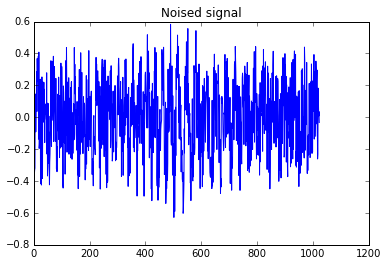

In [11]:
plt.plot(np.real(noised_signal))
plt.title("Noised signal")

In [12]:
# Your code with Wavelet decomposition and thresholding

In [ ]:
# Plot detailed info about coefficients

In [ ]:
# Your code with Wavelet reconstruction

In [13]:
# Plot results

In [14]:
# Your code with FFT transformation

In [15]:
# Plot frequencies

In [17]:
# Your code with FFT thresholding

In [18]:
# Plot thresholded frequencies

In [19]:
# Your code with IFFT

In [20]:
# Plot results

In [21]:
# Compare results

##  2-d image noise reduction

In this exercisse you will remove blur and salt and pepper noise from an image

####Salt and pepper

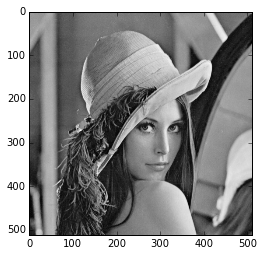

In [95]:
lena = misc.lena()
plt.imshow(lena, cmap=plt.cm.gray)

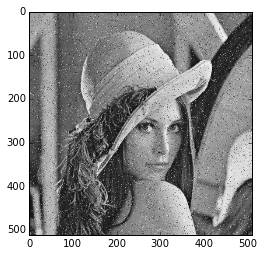

In [96]:
noise = util.random_noise(image=lena, mode='s&p', amount=0.1)
noisy_lena = lena*(1 != noise)
noisy_lena += lena*(0 != noise)
noisy_lena += 255*(1 == noise)
noisy_lena += 0*(0 == noise)
plt.imshow(noisy_lena, cmap='gray')

In [97]:
# Your code with Wavelet decomposition

In [98]:
# Plot matrix coeff

In [99]:
# Your code with thresholding and reconstruction

In [100]:
# Show removed from noise image

In [101]:
# Compute MSE

#### Blure

In [108]:
blurred_lena = ndimage.gaussian_filter(lena, 3)

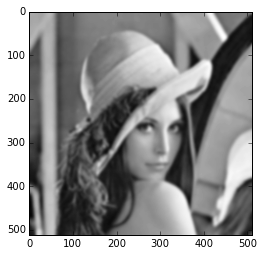

In [109]:
plt.imshow(blurred_lena, cmap='gray')

In [110]:
# Your code with Wavelet decomposition

In [111]:
# Plot matrix coeff

In [112]:
# Your code with thresholding and reconstruction

In [113]:
# Show removed from noise image

In [114]:
# Compute MSE

## 1-d signal frequency change
In this task your goal is to find where frequency of given signal changed. In order to do that observe how detailes of decomposition changes with levels of decomposition.

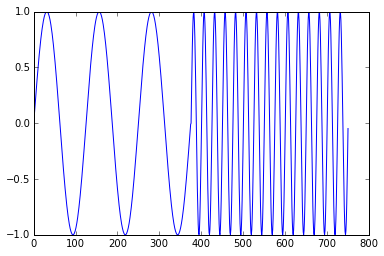

In [130]:
lowfq_t = np.linspace(0,6*3.14,120*3.14)
hifghfq_t = np.linspace(6*3.14,12*3.14,120*3.14)
low_fm = np.sin(lowfq_t)
high_fm = np.sin(5*lowfq_t)
wave=np.append(low_fm,high_fm)
plt.plot(wave)

In [131]:
# Your code | decompose signal with proper wavelet and check details
# To plot detailed info about coefficients withoud threshoding call:
# plot_detailed_decomposition_coefficients(coeffs, coeffs, None)